#Tambahkan value aneh, dengan menggunakan .unique
object sama string beda
agent lebih baik diganti menjadi string
stage 1 nggak papa mengubah tipe data
Undefined meal jadi NAN
Reservation status date di cacah jadi tanggal, bulan, tahun
Email : gmail dll
Credit card dicacah coba dicari maknanya
Pemodelan pilih fitur yang korelasi tinggi dengan target (lebih dari 0.7 atau kurang dari 0.7)
Feature selection
anova f test: feature numeric, target categoric
chi square: feature categoric, terget categoric

Kategorik
ordinal ada ranking
nominal setara

Distribusi
Ditentukan, lalu handling

Point statement
Treatment nya

Outlier pakai IQR

Feature transformation

assigned room type apakah available?

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [14]:
#import library FP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Normality test
from scipy.stats import shapiro
from scipy.stats import normaltest

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
!pip install category_encoders
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier

# Model
import xgboost as xgb
import statsmodels.api as sm 

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Target merupakan cancelation rate (is_canceled)
df = pd.read_csv("hotel_booking.csv") #Load original dataset
pd.set_option("display.max_columns", None)
#copy data for backup
df2 = df.copy()

1. Pengecekan kesesuaian data

In [ ]:
#Mengecek kesesuaian tipe data tiap kolom
df.info()

In [ ]:
#Mengecek kesesuaian tipe data tiap kolom
df.describe()

Dari hasil di df.info(), terlihat bahwa terdapat beberapa tidak kesesuaian data:
a. Kolom “is_cancelled”, “is_repeated_guest”, ”previous_cancellations”, “previous_bookings_not_canceled” lebih tepat jika tipe datanya boolean
b. Kolom “children”,’’agent”,”company” akan lebih tepat menggunakan tipe data integer
c. Kolom “reservation_status_date” mempunyai data type berupa object, namun lebih tepat bila menggunakan tipe data datetime

In [ ]:
#Mengecek adanya nilai 0 di kolom
df.isna().sum()

Kolom country, children, agent, dan company memiliki nilai null

Dari hasil command df.describe(), tidak terlihat adanya nilai aneh dari kolom kolom. Semua parameter statistik deskriptif terlihat normal

2. Univariate Analysis untuk melihat distribusi masing masing kolom

Dari kolom kolom yang ada dikelompokan terlebih dahulu, mana kolom yang numerik, dan kategorikal untuk menghindari grafik distribusi yang tidak sesuai 

In [3]:
#Pengelompokan kolom kolom numerik, dan kategorikal
numeric = ['lead_time','arrival_date_year', 'arrival_date_week_number','arrival_date_day_of_month', 'stays_in_weekend_nights','stays_in_week_nights',
           'adults','children','babies','booking_changes', 'days_in_waiting_list','adr','required_car_parking_spaces','total_of_special_requests']

categorical = ['hotel','is_canceled','arrival_date_month','meal','country','market_segment','distribution_channel','is_repeated_guest',
               'previous_cancellations','previous_bookings_not_canceled','reserved_room_type','assigned_room_type','deposit_type','agent','company',
               'customer_type','reservation_status','reservation_status_date','name','email','phone-number','credit_card']

#Setelah melihat dataset kaggle, kami mengambil kesimpulan bahwa agent, dan kompany merupakan sebuah id sehingga dimasukkan dalam tipe kategorikal       

Univariate analysis akan dilakukan pada kolom kolom numerical

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(0, len(numeric)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=df[numeric[i]], color='gray', orient='v')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(0, len(numeric)):
    plt.subplot(4, 4, i+1)
    sns.distplot(df[numeric[i]], color='gray')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(0, len(numeric)):
    plt.subplot(4, 4, i+1)
    sns.violinplot(y=df[numeric[i]], color='gray', orient='v')
    plt.tight_layout()

a.  Kolom “stays_in_week_nights”, “stays_in_weekend_nights”, ”stay_duration”
    mempunyai distribusi positively skewed. (Melihat bentuk box plot, distribution
    plot, dan violin plot). Langkah selanjutnya adalah melakukan menormalkan
    distribusi data, metode yang digunakan bisa menggunakan Log
    transformation, dll. Setelah distribusi data menjadi normal, selanjutnya kita
    lakukan feature scaling bisa berupa Min-max scaler, standard scaler, dan
    robust scaler, dll.
b. Terdapat beberapa kolom yang memiliki outliers, seperti kolom
   “total_of_special_requests”, “required_car_parking_spaces”, “children”,
   “babies”, “adults”. Dari box plot, terdapat beberapa jenis outlier seperti global
   outlier dan collective outlier. Untuk pemodelan, biasanya kita membuang
   global outlier (outlier yang sangat ekstrem), sementara kita membiarkan
   collective outlier tetap ada.
c. Terdapat beberapa nilai yang mendominasi, contohnya nilai 0 pada kolom
   “babies”, 0 pada kolom children, “stay duration” yang mendominasi tidak lebih
   dari 10 hari, dll.

3. Multivariate Analysis

In [ ]:
#Dilakukan correlation untuk tiap2 kolom untuk mencari kolom yang paling tepat untuk dijadikan feature
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

Untuk korelasi antara feature dan label (“is_cancelled”) tidak memiliki korelasi yang kuat. Adapun feature yang bertipe numerik ternyata berupa ID, yaitu “Agent”, ”company”. Kolom tersebut direkomendasikan untuk didrop sementara feature yang lain masih relevan untuk eksplorasi lebih lanjut

Dari correlation heatmap, kita dapat memperoleh korelasi antar feature. Jika korelasi > 0.7 artinya terdapat hubungan 2 feature yang menandakan
multikolinieritas/redundan sehingga salah satu feature harus dibuang. Pada diagram heatmap diperoleh bahwa fitur yang menunjukkan kolom stay berkorelasi > 0.7. Selain itu, feature yang menunjukkan guest juga berkorelasi >0.7

4. Business Insights

Terdapat beberapa insight yang dapat diambil seperti:

In [ ]:
# Durasi stay pelanggan kurang dari 10 hari
# sns.set_style('whitegrid')
# sns.set(rc={'figure.figsize':(10,10)})
# sns.catplot(x= df['stays_in_weekend_nights'] + df['stays_in_week_nights'],
#             data=df, 
#             kind="count",height = 10, aspect = 2)

Dari hal ini pihak hotel dapat memfokuskan usaha pada pelanggan yang melakukan short stay duration saja. Misal, melakukan promo tambahan
breakfast dan lunch pada pelanggan yang hanya stay selama 2 hari dengan tambahan biaya, sehingga dapat memaksimalkan profit.

In [ ]:
# #Pelanggan tidak banyak menggunakan mobil untuk stay
# sns.set_style('whitegrid')
# sns.set(rc={'figure.figsize':(10,10)})
# sns.catplot(x='required_car_parking_spaces', 
#             data=df, 
#             kind="count",height = 5, aspect = 2)

Hal ini dapat menjadi peluang bisnis bagi pihak hotel untuk menyediakan moda transportasi untuk pelanggan hotel yang ingin berwisata, maupun pergi
menuju ke airport, atau bandara (Bisa menyediakan jasa sewa sopir)

Stage 2 Preprocessing

1. Data Cleansing

In [4]:
## Handling missing values
# Nilai null di column 'children' mungkin keluarga tidak mempunyai anak
df['children'] = df['children'].fillna(0)
# Dari kaggle dataset column 'agent', dan 'company' merupakan sebuah id. 
#Sehingga null value, kemungkinan memiliki arti bahwa pengunjung tidak memesan melalui 'agent' dan 'company' sehingga dimasukkan 0 
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)
# Dari kaggle dataset column 'country' merupakan singkatan nama negara.
# Maka null kemungkinan berarti tidak punya negara maka null akan di isi 'NON' yang berarti tidak punya kewarganegaraan
df['country'] = df['country'].fillna('NON')

In [5]:
#Mengecek data duplikat
print('Baris dengan data duplikat:', df.duplicated().sum())

Baris dengan data duplikat: 0


In [6]:
#Memperbaiki tipe data
df['children'] = df['children'].astype('int64')
df['agent'] = df['agent'].astype('int64')
df['company'] = df['company'].astype('int64')
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

In [ ]:
#Mengecek nilai aneh di kolom meal
df['meal'].unique()

In [ ]:
# Mengganti Undefined meal sebagai missing Values NAN
df['meal'] = df['meal'].replace(['Undefined'], 'NAN')
df['meal'].value_counts()

In [7]:
# #Handle outlier
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')
filtered_entries = np.array([True] * len(df))

for col in numeric:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 119390
Jumlah baris setelah memfilter outlier: 98480


In [8]:
# Menghilangkan data yang bernilai 0 guest, dan 0 malam
# Melakukan feature ekstrasi berupa, pembuatan kolom baru total guest, dan stay duration
df['total_guests'] = df['adults'] + df['children'] + df['babies']
print('Data with 0 guest: {0} out of {1} all data'.format(df[df['total_guests'] == 0].shape[0], df.shape[0]))
df['stay_duration'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
print('Data with 0 night: {0} out of {1} all data'.format(df[df['stay_duration'] == 0].shape[0], df.shape[0]))
# Pembuatan df baru untuk data yang telah dipre process
df_clean = df[(df['total_guests'] > 0) & (df['stay_duration'] > 0)].copy()

print('before pre-processing:', df.shape[0])
print('after pre-processing:', df_clean.shape[0])

Data with 0 guest: 0 out of 98480 all data
Data with 0 night: 590 out of 98480 all data
before pre-processing: 98480
after pre-processing: 97890


In [9]:
#Mengedrop kolom tdk berguna di dataset
df_clean = df_clean.drop(columns = ['adults','children','babies','stays_in_weekend_nights','stays_in_week_nights'])

In [ ]:
df_clean.info()

In [ ]:
df_clean

In [10]:
#Menyimpan ke csv file baru
df_clean.to_csv('Data_Hotel_Cleaning.csv', index=False)

#df_baru

In [3]:
#Meload df baru
df_baru = pd.read_csv("Data_Hotel_Cleaning.csv")

In [4]:
#Pembuatan backup df
df_backup = df_baru.copy()

In [ ]:
pd.set_option("display.max_columns", None)
df_baru

In [ ]:
df_baru['reservation_status'].unique()

In [5]:
column_to_delete = ['credit_card','phone-number','name','agent','company','email','reservation_status_date','required_car_parking_spaces'
                    ,'assigned_room_type','reserved_room_type','distribution_channel','market_segment','country', 'meal','arrival_date_day_of_month',
                    'arrival_date_week_number','arrival_date_month','arrival_date_year']

In [6]:
df_baru = df_baru.drop(column_to_delete,axis=1)

In [7]:
df_baru.shape

(97890, 15)

In [16]:
nums1 = ['lead_time', 'stay_duration','total_guests','booking_changes','days_in_waiting_list','adr','total_of_special_requests'
         ,'previous_bookings_not_canceled','previous_cancellations']
scaler = StandardScaler()
power = PowerTransformer(method='yeo-johnson')
numeric_pipe = Pipeline([
   ('scaler', scaler),
   ('power', power)  
])

ordinal_cat = ['deposit_type','reservation_status','is_repeated_guest']
deposit_type_rank = ['No Deposit', 'Refundable','Non Refund']
reservation_status_rank = ['Canceled','No-Show','Check-Out']
is_repeated_guest_rank = [0, 1]
ordinalencoder = OrdinalEncoder(categories=[deposit_type_rank, reservation_status_rank, is_repeated_guest_rank])
ordinal_pipe = Pipeline([
        ('ordinalencoder', ordinalencoder)  
])

nominal_cat = ['customer_type','hotel']
onehotencoder = OneHotEncoder(handle_unknown='ignore', drop = 'first')
nominal_pipe = Pipeline([ 
    ('onehotencoder', onehotencoder)
])

In [17]:
preprocessor = ColumnTransformer([
    ('numeric_pipe', numeric_pipe, nums1),
    ('ordinal_pipe', ordinal_pipe, ordinal_cat),
    ('nominal_pipe', nominal_pipe, nominal_cat)
])

In [ ]:
df_baru.shape

In [17]:
pd.Series(['lead_time', 'stay_duration','total_guests','booking_changes','days_in_waiting_list','adr','total_of_special_requests'
         ,'previous_bookings_not_canceled','previous_cancellations','deposit_type','reservation_status','is_repeated_guest',
          'customer_type','hotel']).nunique()

14

In [8]:
#splitting data
X = df_baru.drop(columns=['is_canceled'])
y = df_baru['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((78312, 14), (19578, 14), (78312,), (19578,))

In [9]:
#sampling
X_train = X_train.sample(frac = 1)
X_test = X_test.sample(frac = 1)
y_train = y_train.sample(frac = 1)
y_test =  y_test.sample(frac = 1)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((78312, 14), (19578, 14), (78312,), (19578,))

In [80]:
y_train.value_counts(normalize = True)

0    0.603982
1    0.396018
Name: is_canceled, dtype: float64

In [81]:
y_test.value_counts(normalize = True)

0    0.603994
1    0.396006
Name: is_canceled, dtype: float64

In [21]:
#cross validation
models = [
    #['Logistic Regression', LogisticRegression()],
    ['KNN', KNeighborsClassifier()],
    ['Decision Tree', DecisionTreeClassifier(random_state=42)],
    ['Random Forest', RandomForestClassifier(random_state=42)]
]
def cross_validation(models):
    model_name = []

    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    
    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []
    
    cv_f1_mean = []
    cv_f1_std = []
    training_f1 = []
    
    cv_roc_auc_mean = []
    cv_roc_auc_std = []
    training_roc_auc = []

    for name, model in models:
    
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ]) 
        model_name.append(name)

        #scoring
        scoring= ['recall', 'precision', 'f1', 'roc_auc']
        
        #cross_validate 
        cv_score = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=10, n_jobs = -1,return_train_score=True)
        
        # training
        training_recall.append(abs(cv_score['train_recall']).mean())
        training_precision.append(abs(cv_score['train_precision']).mean())
        training_f1.append(abs(cv_score['train_f1']).mean())
        training_roc_auc.append(abs(cv_score['train_roc_auc']).mean())
        
        #tes                  
        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())
        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())
        cv_f1_mean.append(abs(cv_score['test_f1']).mean())
        cv_f1_std.append(abs(cv_score['test_f1']).std())
        cv_roc_auc_mean.append(abs(cv_score['test_roc_auc']).mean())
        cv_roc_auc_std.append(abs(cv_score['test_roc_auc']).std())
        

    return pd.DataFrame({
        'Model': model_name,
        'Training Recall' : training_recall,
        'CV Recall (mean)': cv_recall_mean,
        'CV Recall (std)': cv_recall_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)' : cv_precision_mean,
        'CV Precision (std)' : cv_precision_std,
        'Training F1' : training_f1,
        'CV F1 (mean)' : cv_f1_mean,
        'CV F1 (std)' : cv_f1_std,
        'Training AUC_ROC' : training_roc_auc,
        'CV AUC_ROC (mean)' : cv_roc_auc_mean,
        'CV AUC_ROC (std)' : cv_roc_auc_std,
    })

In [87]:
cv_result = cross_validation(models)

In [88]:
cv_result

,Model,Training Recall,CV Recall (mean),CV Recall (std),Training Precision,CV Precision (mean),CV Precision (std),Training F1,CV F1 (mean),CV F1 (std),Training AUC_ROC,CV AUC_ROC (mean),CV AUC_ROC (std)
0,KNN,0.484532,0.307581,0.007456,0.617171,0.390679,0.006482,0.542856,0.344169,0.006909,0.710530,0.497889,0.004633
1,Decision Tree,0.718305,0.321026,0.005209,0.929847,0.394929,0.005641,0.810496,0.354142,0.004663,0.957014,0.499465,0.004868
2,Random Forest,0.758302,0.274434,0.009354,0.889493,0.391027,0.007085,0.818671,0.322486,0.008660,0.952467,0.496504,0.004652


In [76]:
#Hyperparameter Tuning (Randomizer)
#Hyptun Logistic Regression

randomforest = RandomForestClassifier()

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('algo', randomforest)
    ])

param = {'algo__n_estimators': [100, 150, 200],
 'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10]}


rs_rf = RandomizedSearchCV(estimator=pipeline, param_distributions=param, scoring='roc_auc', random_state=42, cv=10, n_jobs=-1, verbose=1)
rs_rf.fit(X_train, y_train)

print(rs_rf.best_params_)
print(rs_rf.score(X_train, y_train), rs_rf.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'algo__n_estimators': 100, 'algo__min_samples_leaf': 1, 'algo__max_features': 0.3, 'algo__max_depth': 20}
0.9031160633985779 0.5087268954301079


In [23]:
randomforest = RandomForestClassifier(n_estimators = 100, min_samples_leaf= 1,max_features = 0.3,max_depth = 20)
model = Pipeline([
        ('preprocessor', preprocessor),
        ('algo', randomforest)
    ]).fit(X_train, y_train)

In [97]:
y_pred = model.predict(X_test) 

In [98]:
roc_auc_score(y_test,y_pred)

0.499524706933332

              precision    recall  f1-score   support

           0       0.67      0.99      0.80     47299
           1       0.92      0.26      0.41     31013

    accuracy                           0.70     78312
   macro avg       0.80      0.62      0.60     78312
weighted avg       0.77      0.70      0.65     78312



Text(56.5, 0.5, 'Realita')

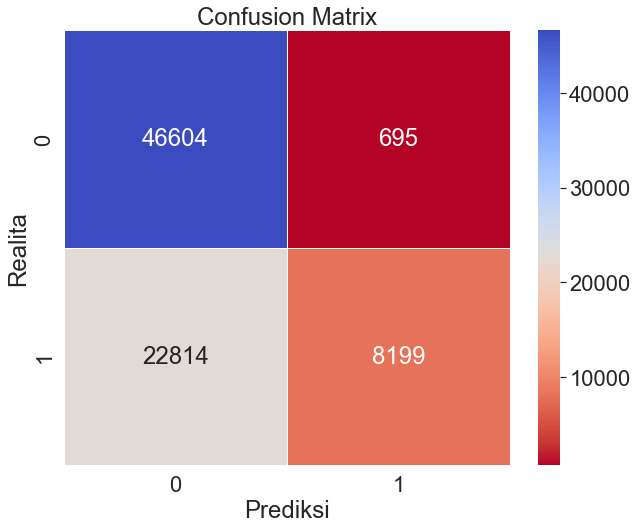

In [ ]:
#confusion pada data train logreg
plt.rcParams['figure.figsize'] = (10,8)
sns.set(font_scale=2)
cnf_matrix = metrics.confusion_matrix(y_train, model.predict(X_train))
print(metrics.classification_report(y_train, model.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')

plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [33]:
X_train

,hotel,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,total_of_special_requests,reservation_status,total_guests,stay_duration
93517,City Hotel,67,0,0,0,0,No Deposit,0,Transient,95.76,1,Check-Out,2,3
75263,City Hotel,254,0,0,0,0,No Deposit,0,Transient-Party,100.70,1,Check-Out,2,1
33502,City Hotel,102,0,0,0,0,Non Refund,0,Transient-Party,101.50,0,Canceled,2,2
57636,City Hotel,179,0,0,0,0,No Deposit,0,Transient,118.80,0,Canceled,2,2
42074,City Hotel,25,0,0,0,0,No Deposit,0,Transient,187.00,1,Canceled,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84078,City Hotel,0,0,0,0,0,No Deposit,0,Transient,87.00,0,Check-Out,1,1
55816,City Hotel,215,0,0,0,0,Non Refund,0,Transient,110.00,0,Canceled,2,4
38402,City Hotel,146,0,0,0,0,No Deposit,0,Transient,121.55,1,Check-Out,2,3
13839,Resort Hotel,0,1,0,4,0,No Deposit,0,Transient,39.00,1,Check-Out,1,1


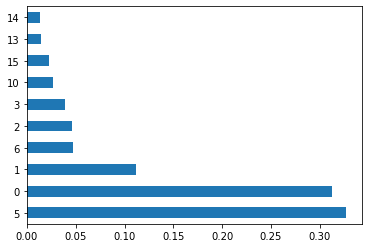

In [32]:
feat_importances = pd.Series(model.steps[1][1].feature_importances_)
feat_importances.nlargest(10).plot.barh()
plt.show()

In [ ]:
#Label deposit_type one hot encoding
new = pd.get_dummies(df_baru['deposit_type'], prefix='tipe')
df_baru['tipe_No Deposit'] = new['tipe_No Deposit']
df_baru['tipe_Non Refund'] = new['tipe_Non Refund']
df_baru['tipe_Refundable'] = new['tipe_Refundable']

In [ ]:
#label reservation_status one hot encoding
new1 = pd.get_dummies(df_baru['reservation_status'], prefix='tipe')
df_baru['tipe_Check-Out'] = new1['tipe_Check-Out']
df_baru['tipe_Canceled'] = new1['tipe_Canceled']
df_baru['tipe_No-Show'] = new1['tipe_No-Show']

In [ ]:
#label customer_type one hot encoding
new2 = pd.get_dummies(df_baru['customer_type'], prefix='tipe')
df_baru['tipe_Transient'] = new2['tipe_Transient']
df_baru['tipe_Contract'] = new2['tipe_Contract']
df_baru['tipe_Transient-Party'] = new2['tipe_Transient-Party']
df_baru['tipe_Group'] = new2['tipe_Group']

In [ ]:
mapping = {'Resort Hotel':0,
           'City Hotel': 1}
df_baru['hotel'] = df_baru['hotel'].map(mapping)

In [ ]:
cat2 = ['tipe_No Deposit','tipe_Non Refund','tipe_Refundable','tipe_Check-Out','tipe_Canceled','tipe_No-Show','tipe_Transient','tipe_Contract',
        'tipe_Transient-Party','tipe_Group','hotel']

In [ ]:
feature = nums1 + cat2

In [ ]:
df_baru.info()

In [ ]:
for i in range(0, len(nums1)):
     df_baru[nums1[i]]= np.log(df_baru[nums1[i]]+1) #Logaritmik nggak bisa tanpa 0, harus tambah 1

In [ ]:
pd.set_option("display.max_columns", None)
df_baru

In [ ]:
#Scaling
#df_baru['stay_duration'] = StandardScaler().fit_transform(df_baru['stay_duration'].values.reshape(len(df_baru), 1))
#df_baru['total_guests'] = StandardScaler().fit_transform(df_baru['total_guests'].values.reshape(len(df_baru), 1))

In [ ]:
df_baru.info()

# Modelling

In [ ]:
# pemisahan features vs target
#X = df_baru.drop('is_canceled', axis=1)
X = df_baru[feature].values
y = df_baru['is_canceled'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

##XGboost

In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
eval_classification(xg)

##XGboost (Hyperparameter Tuning)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned)

percobaan 2

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(xg_tuned)

In [ ]:
!pip install shap

In [ ]:
from matplotlib import pyplot
pyplot.bar(range(len(xg.feature_importances_)), xg.feature_importances_)
pyplot.show()

##Decision Tree

In [ ]:
# decision tree
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train, y_train) # fit model decision tree dari data train
eval_classification(dt)

##Decision Tree (Hyperparameter Tuning)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
model = GridSearchCV(dt, hyperparameters, cv=5, scoring='precision')
model.fit(X_train, y_train)

# Predict & Evaluation
y_pred = model.predict(X_test)#Check performa dari model
eval_classification(model)

In [ ]:
print("s")